# Overview

This Jupyter notebook predicts large-area tiles downloaded in `4a-download-large-area` with a trained model from `3-model-master`. The notebook is broken down into the following sections:

   * **Model loading**:
   * **Coordinate identification**
   * **Tiling**
   * **Loading and predicting**
   * **Mosaicing**
   * **Writing TIF**
   * **Writing COG**

# 1.0 Package imports

In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from scipy.ndimage import median_filter
from skimage.transform import resize
import hickle as hkl
from time import sleep

%run ../src/downloading/utils.py
%run ../src/models/utils.py

Using TensorFlow backend.


# 1.1 Parameter definitions

In [2]:
LANDSCAPE = 'cameroon-mogazang'
YEAR = 2019


In [3]:
database = pd.read_csv("../project-monitoring/database.csv")
coords = database[database['landscape'] == LANDSCAPE]
path = coords['path'].tolist()[0]
coords = (float(coords['longitude']), float(coords['latitude']))

IO_PARAMS = {'prefix': '../',
             'bucket': 'restoration-monitoring',
             'coords': coords,
             'bucket-prefix': '',
             'path': path}

OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + '/output/'
TIF_OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + ".tif"
INPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + '/processed/'

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
print(coords, OUTPUT)

(14.210755, 10.633414) ../project-monitoring/cameroon/far-north/maroua/2019/output/


# 2.0 Model loading

In [4]:
path = '../models/master-2021-11750/'
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

In [5]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")


#inp_median = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

## 2.2 Tiling functions

In [6]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 2)
arr = arr[:7, :7]

SIZE = 10
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)

arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums

100 81 90 90 361


# 2.3 Prediction functions

In [7]:
# 7300 samples
min_all = [0.013473716334782941, 0.026749065384908823, 0.015594720378423743, 0.04151979858091097, 0.041794460975051496, 0.04419012741283284, 0.046387426565957124, 0.03997863736934462, 0.029922941939421684, 0.022613870450904097, 0.0, -0.03150988021667811, -0.4017853055619135, -0.020706492713817082, -0.17936980239566647, 0.49647595452889137, 0.036705339246950075]
max_all = [0.2135957885099565, 0.31784542610818645, 0.4665445944914931, 0.5549248493171588, 0.5132982375829709, 0.5258716716258488, 0.5463492790112153, 0.557778286411841, 0.7029221026932173, 0.6533150225070573, 0.420202944991226, 0.7505455100328069, 0.3344625009536888, 0.6910658426794842, 0.8989242389562828, 0.9640911367847687, 0.8307561131659074]

# 10250 samples
min_all = [0.012680247196154727, 0.025696192874036773, 0.015335317006179903, 0.045014114595254444, 0.040924696726939803, 0.047470817120622566, 0.049927519645990695, 0.04351873044937819, 0.027344167238879988, 0.019943541618982222, 0.0, -0.03862058442053862, -0.4059052414740215, -0.02613870450904099, -0.18538185702296484, 0.4994787833207808, 0.036705339246950075]
max_all = [0.2144045166704814, 0.3134355687800412, 0.4580300602731365, 0.5453721675441149, 0.504097047379263, 0.5171740291447319, 0.5381551842526894, 0.5497062638284886, 0.6925154497596704, 0.6404211490043488, 0.42020294499122607, 0.7460593575951782, 0.3305867093919279, 0.6874341954680705, 0.898161287861448, 0.9669493083796132, 0.8337636829655277]

# GRNDVI

min_all = [0.012726024261844816, 0.025741969939726862, 0.015365835049973294, 0.04444953078507668, 0.04090943770504311, 0.04702830548561837, 0.04936293583581292, 0.042969405661097124, 0.02673380636301213, 0.019562066071564813, 0.0, -0.039597161821927185, -0.4055085069047074, -0.02751201647974366, -0.5080387335466494, 0.4994787833207808, 0.036705339246950075] 
max_all = [0.21391622796978713, 0.3129167620355535, 0.4574807354848554, 0.5446860456244754, 0.5035172045471885, 0.5166094453345541, 0.537621118486305, 0.5491264209964142, 0.6919050888838025, 0.6396734569314106, 0.42020294499122607, 0.7455100328068971, 0.3302204928664072, 0.6869459067673762, 0.7157240565415754, 0.9673748605671116, 0.8341312927789295]

# 11750
min_all = [0.012558175020981156, 0.025696192874036773, 0.01539635309376669, 0.04478522926680399, 0.04068055237659266, 0.04710460059510185, 0.049881742580300606, 0.04361028458075837, 0.02818341344319829, 0.02026398107881285, 0.0, 0.5419731947249189, 0.2969113383797463, -0.03367114973145012, -0.40432315843766126, -0.02335820986187474, -0.4988996431782181] 
max_all =  [0.2126802471961547, 0.3093308918898299, 0.45065995269703213, 0.5368581673914702, 0.4968947890440223, 0.5098954757000076, 0.5315938048371099, 0.5438315403982604, 0.6847180895704585, 0.6326390478370336, 0.41567101548790725, 0.948365434839523, 0.8137210160767949, 0.7460347679428321, 0.3274571766911071, 0.6886312522154149, 0.7143557051870734]

In [8]:
database = pd.read_csv("qaqcecoregion.csv")
database.head(5)
landscape = 91

coords = database[database['id'] == landscape]
coords = (float(coords['X']), float(coords['Y']))

OUTPUT = '../project-monitoring/qa-qc-ecoregion/'+ str(landscape) + '/2020/output/'
INPUT = '../project-monitoring/qa-qc-ecoregion/'+ str(landscape) + '/2020/processed/'
TIF_OUTPUT = '../project-monitoring/qa-qc-ecoregion/'+ str(landscape) + f'/2020/out_{str(landscape)}.tif'

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
print(coords, OUTPUT)
database.to_csv("qaqc.csv", index = False)

(35.63043279, -10.62830375) ../project-monitoring/qa-qc-ecoregion/91/2020/output/


In [9]:
def convert_to_db(x, min_db):
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = x + min_db
    x = x / min_db
    x = np.clip(x, 0, 1)
    return x

def grndvi(array):
    nir = np.clip(array[..., 3], 0, 1)
    green = np.clip(array[..., 1], 0, 1)
    red = np.clip(array[..., 2], 0, 1)
    denominator = (nir+(green+red)) + 1e-5
    return (nir-(green+red)) / denominator

def evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the enhanced vegetation index
    2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    '''

    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = x[..., 2]
    NIR = x[..., 3]
    evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))
    evis = np.clip(evis, -1.5, 1.5)
    return evis

def msavi2(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the modified soil-adjusted vegetation index 2
    (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR-RED)) / 2
    '''
    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = np.clip(x[..., 2], 0, 1)
    NIR = np.clip(x[..., 3], 0, 1)

    msavis = (2 * NIR + 1 - np.sqrt( (2*NIR+1)**2 - 8*(NIR-RED) )) / 2
    return msavis

def bi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    B11 = np.clip(x[..., 8], 0, 1)
    B4 = np.clip(x[..., 2], 0, 1)
    B8 = np.clip(x[..., 3], 0, 1)
    B2 = np.clip(x[..., 0], 0, 1)
    bis = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    return bis


def load_and_predict_folder(y_col, folder, overlap_filter = upright,
                            normal_filter = normal, histogram_match = False):
    """Insert documentation here
    """
    pred_files = INPUT + str(y_col) + "/" + str(folder) + ".hkl"    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }
    
    pred_x = []
    x = hkl.load(pred_files)
    if not isinstance(x.flat[0], np.floating):
        assert np.max(x) > 1
        x = x / 65535.
        
    x[..., -1] = convert_to_db(x[..., -1], 50)
    x[..., -2] = convert_to_db(x[..., -2], 50)

    indices = np.empty((12, 142, 142, 4))
    indices[..., 0] = evi(x)
    indices[..., 1] = bi(x)
    indices[..., 2] = msavi2(x)
    indices[..., 3] = grndvi(x)
    
    #s1 = x[..., -2:]
    #x = x[..., :-2]
    
    print(x.shape)
    x = np.concatenate([x, indices], axis = -1)
    #x = np.concatenate([x, s1], axis = -1)
    
    med = np.median(x, axis = 0)
    med = med[np.newaxis, :, :, :]
    print(med.shape)
    print(x.shape)
    x = np.concatenate([x, med], axis = 0)
    print(x.shape)

    filtered = median_filter(x[0, :, :, 10], size = 5)
    x[:, :, :, 10] = np.stack([filtered] * x.shape[0])
    x = tile_images(x)
    pred_x = np.stack(x)   
    for band in range(0, pred_x.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        pred_x[..., band] = np.clip(pred_x[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[..., band] - midrange) / (rng / 2)
        pred_x[..., band] = standardized
        
    #pred_x = pred_x[..., :-2]
    print(pred_x.shape)
    print(np.max(pred_x[..., -1]))

    preds = []
    batches = [x for x in range(0, 341, 20)] + [361]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        lengths = np.full((batch_x.shape[0], 1), 12)
        batch_pred = sess.run(logits,
                              feed_dict={inp:batch_x, 
                                         clipping_params['rmax']: 5,
                                         clipping_params['rmin']: 0,
                                         clipping_params['dmax']: 3,
                                         length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0) * normal

    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

# Development Code

# 2.4 Run predictions

In [10]:
all_preds = []
for row in tnrange(0, (1*5)): 
    for column in range(0*5, (1*5)):
        output_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        input_file = f"{INPUT}{str(row)}/{str(column)}.hkl"
        
        if os.path.exists(input_file) and not os.path.exists(output_file):
            print(output_file)
            prediction = load_and_predict_folder(row, column, histogram_match = False)
            if not os.path.exists(OUTPUT + str(row) + "/"):
                os.makedirs(OUTPUT + str(row) + "/")
            prediction = prediction[7:-7, 7:-7]
            np.save(output_file, prediction)

../project-monitoring/qa-qc-ecoregion/91/2020/output/2/1.npy



ValueError: could not broadcast input array from shape (13,142,142) into shape (12,142,142)


# 2.5 Mosaic predictions

In [39]:
max_x = 1*5#41*5
max_y = 1*5#24*5

start_x = 0*5
start_y = 0*5

predictions = np.full(
    ((max_y-start_y)*126,
     (max_x-start_x)*126), 0, dtype = np.uint8 )

max_y_out = predictions.shape[0]
max_x_out = predictions.shape[1]

numb = 0
for row in tnrange(start_y, max_y):
    for column in range(start_x, max_x):
        input_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        if os.path.exists(input_file):
            prediction = np.load(input_file)
            x_value = (column-start_x) *126
            y_value = (max_y_out - ((row - start_y + 1) *126))
            if (row % 5 == 0) and (column % 5 == 0):
                numb += 1
            prediction = np.around(prediction * 10, 0) * 10
            
            predictions[y_value:y_value+126, 
                        x_value:x_value+126,
                        ] = (prediction).astype(np.uint8)
            
predictions[predictions < 25] = 0.
print(f"There are {numb*4000} hectares processed")



There are 4000 hectares processed


#### 2.6 Sharpen predictions

In [40]:
def recover_new(arr, thresh):
    """Not currently used. Identifies small trees that may be below the
       threshold for binary map creation.
    """
    adding = 0
    stacked = np.copy(arr)
    for window_x in tnrange(2, stacked.shape[0]-2, 1):
        for window_y in range(2, stacked.shape[1]-2, 1):
            #
            five_w = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
            three_w = stacked[window_x-1:window_x+2, window_y-1:window_y+2]
            
            n_five_above = len(five_w[np.argwhere(five_w > 0.15)])
            n_three_above = len(three_w[np.argwhere(three_w > 0.15)])
            
            n_five_below = len(five_w[np.argwhere(five_w < thresh)])
            
            
            if n_five_below >= 24:                 
                # if less than 2 of the 5x5 are positive
                if n_three_above >= 2 and n_three_above < 6:            
                    # and at least 2 of the 3x3 are above 0.1
                    if n_three_above <= (n_five_above + 4):  
                        # and less than 1/4 of the outer border is above 0.1
                        if np.argmax(three_w) == 4:          
                            # and the center of the 3 x 3 is the largest
                            stacked[window_x, window_y] = -1.
                            adding += 1
    stacked[np.where(stacked == -1)] = 1.
    return stacked

In [41]:
stacked = predictions

threshold = False
if threshold:
    stacked = recover_new(predictions, 0.3)
    stacked[np.where(stacked > thresh_p)] = 0.71
    stacked[np.where(stacked < thresh_p)] = -1
    stacked[np.where(stacked == 1.0)] = 1.

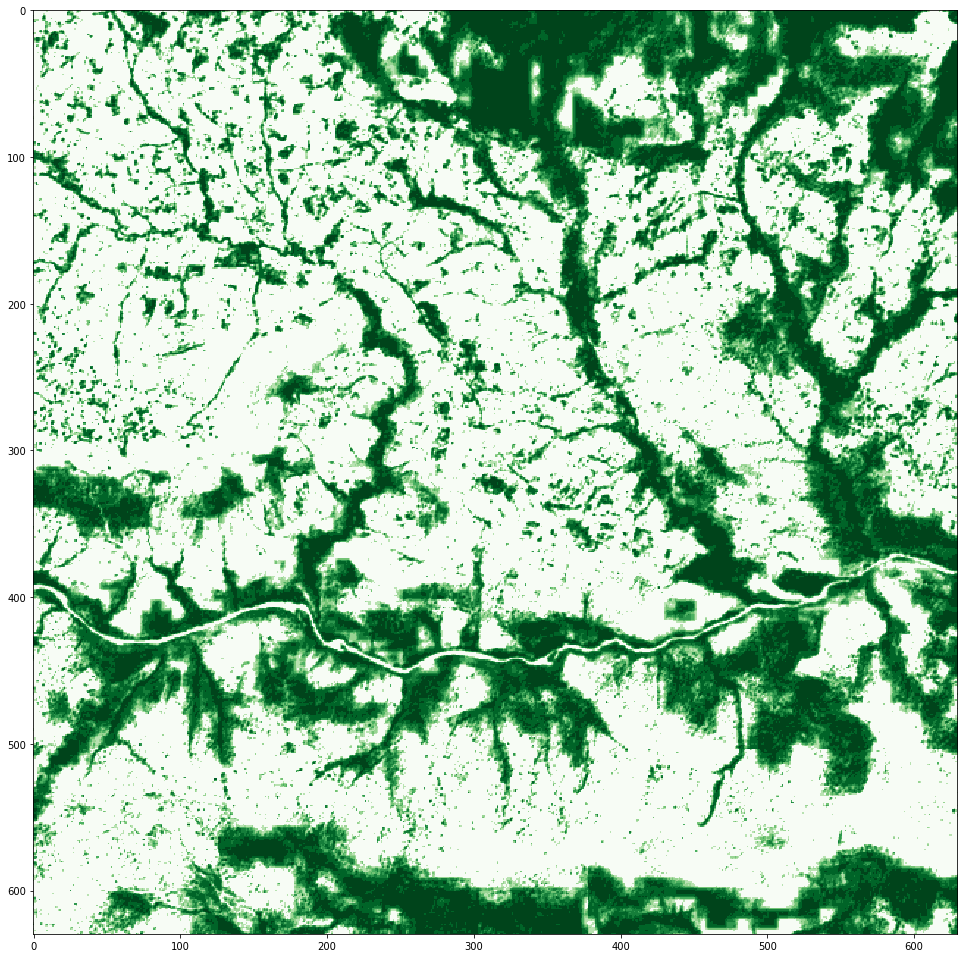

In [42]:
plot = True
if plot:
    plt.figure(figsize=(20,17))
    plt.imshow(stacked, cmap='Greens', vmin=0, vmax=100)
    plt.show()

# 3.0 Write GeoTiff

In [43]:
point = bounding_box(coords, (max_x*1260)-0, ((max_y)*1260)-0, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.uint8)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], 
                                           height = stacked.shape[0])

print("Writing", TIF_OUTPUT)
new_dataset = rasterio.open(TIF_OUTPUT, 'w', driver = 'GTiff',
                           height = stacked.shape[0], width = stacked.shape[1], count = 1,
                           dtype = 'uint8',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

Writing ../project-monitoring/qa-qc-ecoregion/134/2020/out_134.tif


In [23]:
!gdal_translate ../../ce-hosting/includes/niger-koure.tif ../tile_data/cog/niger-koure.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro ../tile_data/cog/niger-koure.tif 2 4 8 16

ERROR 4: ../../ce-hosting/includes/niger-koure.tif: No such file or directory
0...10...20...30...40...50...60...70...80...90...100 - done.


# 3.2 One-hectare tree cover Geotiff

In [ ]:
summed = np.reshape(stacked, (stacked.shape[0] // 10, 10, stacked.shape[1] // 10, 10))
summed = np.mean(summed, (1, 3))

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()